# Hamming weight and Pearson Correlation

This notebook demonstrates how to guess a floating number using Hamming Weight model.

We generate a random secret floating number. Then we use hamming weight model to guess the number.

In [36]:
import pathlib
TEST_RESULT_DIR = './results'

pathlib.Path(TEST_RESULT_DIR).mkdir(parents=True, exist_ok=True) 

In [1]:
import numpy as np

mantissa_nbits = 12
guess_range=(-5.0, 5.0)
# the number of guess values in the guess range
secret_number = np.random.uniform(guess_range[0], guess_range[1]) 
secret_number = -0.4999523029799853
print('secret_number =', secret_number)

secret_number = -0.4999523029799853


## Receover the weight number in step-by-step

In [2]:
import sys
sys.path.append("../")

from batina.weight_recovery import *
from batina.utils import *

### Correlation of mantissa

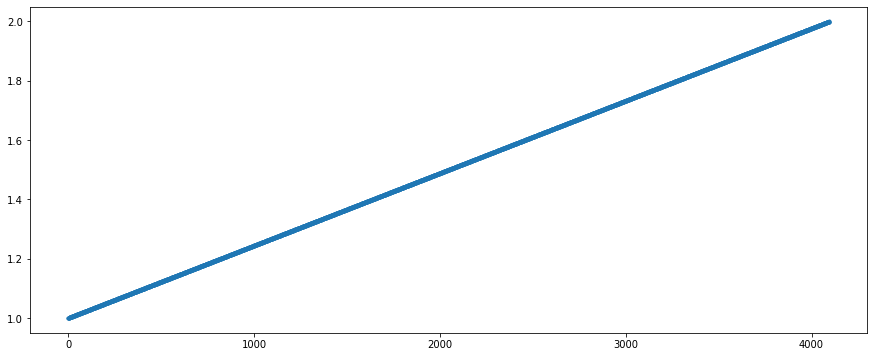

In [3]:
guess_numbers = build_guess_values(component='mantissa', mantissa_nbits=mantissa_nbits, guess_range=guess_range)
known_inputs = build_input_values(mantissa_nbits=mantissa_nbits, component='mantissa')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
pd.Series(guess_numbers).sort_values().reset_index(drop=True).plot(figsize=(15,6), marker='.')

In [4]:
%%time
mantisa_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

CPU times: user 23.1 s, sys: 570 ms, total: 23.6 s
Wall time: 23.6 s


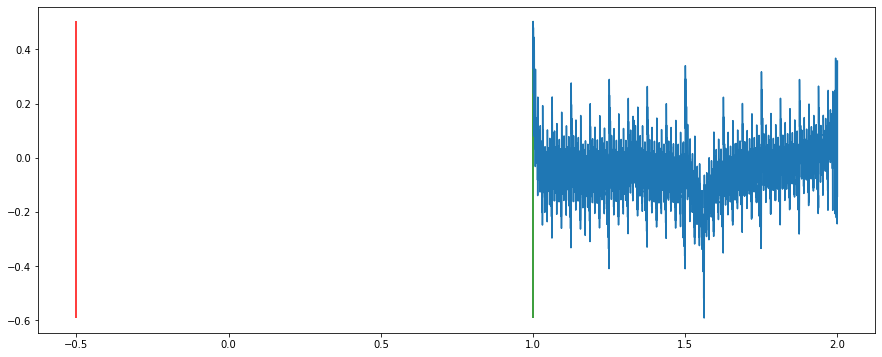

In [5]:
ax = mantisa_corr.sort_index().plot(figsize=(15,6))
ax.vlines(mantisa_corr.idxmax(), mantisa_corr.min(), mantisa_corr.max(), color='green')
ax.vlines(secret_number, mantisa_corr.min(), mantisa_corr.max(), color='red')

In [6]:
mantisa_corr.sort_values(ascending=False).iloc[:10]

1.000244    0.503452
1.000488    0.501760
1.000977    0.480676
1.000000    0.462501
1.001953    0.446017
1.003906    0.397712
1.993896    0.367784
1.999756    0.356851
1.999268    0.355707
1.500244    0.340039
dtype: float64

### Correlation exponent

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
../batina/weight_recovery.py:39: RuntimeWarning: invalid value encountered in greater_equal
  guess_numbers = y[(lo_range <= y) & (y <= hi_range)]
../batina/weight_recovery.py:39: RuntimeWarning: invalid value encountered in less_equal
  guess_numbers = y[(lo_range <= y) & (y <= hi_range)]


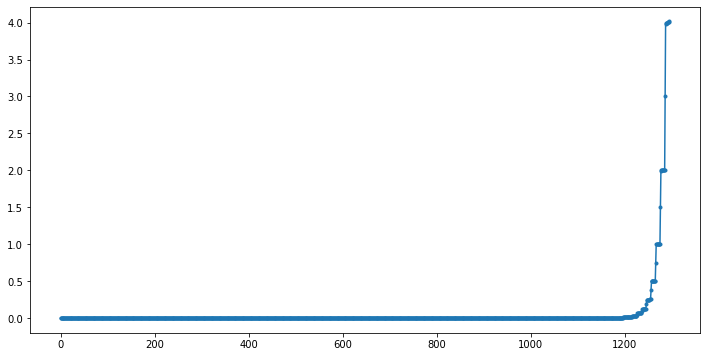

In [7]:
known_inputs = build_input_values(component='exponent')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
guess_numbers = build_guess_values(component='exponent', numbers=mantisa_corr.sort_values(ascending=False).index[:10], guess_range=guess_range)
pd.Series(guess_numbers).sort_values().reset_index(drop=True).plot(figsize=(12,6), marker='.')

In [8]:
%%time
mantisa_exp_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

../batina/weight_recovery.py:80: RuntimeWarning: invalid value encountered in multiply
  data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_numbers))
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


CPU times: user 653 ms, sys: 20 ms, total: 673 ms
Wall time: 672 ms


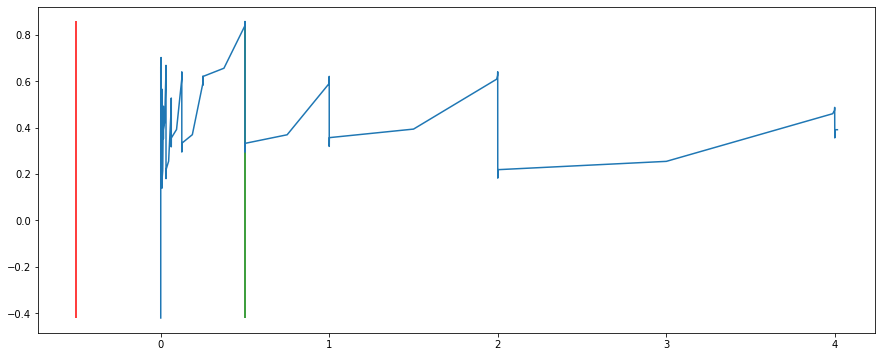

In [9]:
ax = mantisa_exp_corr.sort_index().plot(figsize=(15,6))
ax.vlines(mantisa_exp_corr.idxmax(), mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='green')
ax.vlines(secret_number, mantisa_exp_corr.min(), mantisa_exp_corr.max(), color='red')

In [10]:
mantisa_exp_corr.sort_values(ascending=False).iloc[:10]

0.499939    0.857302
0.499817    0.848339
0.498474    0.837382
0.001953    0.701896
0.001952    0.688335
0.001947    0.672837
0.031246    0.667990
0.000008    0.661438
0.375061    0.655645
0.031239    0.653663
dtype: float64

### Correlation sign

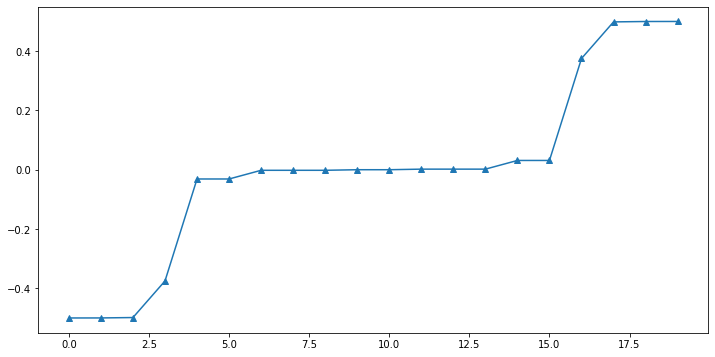

In [11]:
guess_numbers = build_guess_values(component='sign', numbers=mantisa_exp_corr.sort_values(ascending=False).index[:10], guess_range=guess_range)
known_inputs = build_input_values(component='sign')
secret_hw = np.vectorize(hamming_weight)(known_inputs * secret_number)
pd.Series(guess_numbers).sort_values().reset_index(drop=True).plot(figsize=(12,6), marker='^')

In [12]:
%%time
full_number_corr = compute_corr_numbers(secret_hw, known_inputs, guess_numbers)

CPU times: user 25.1 ms, sys: 0 ns, total: 25.1 ms
Wall time: 24.6 ms


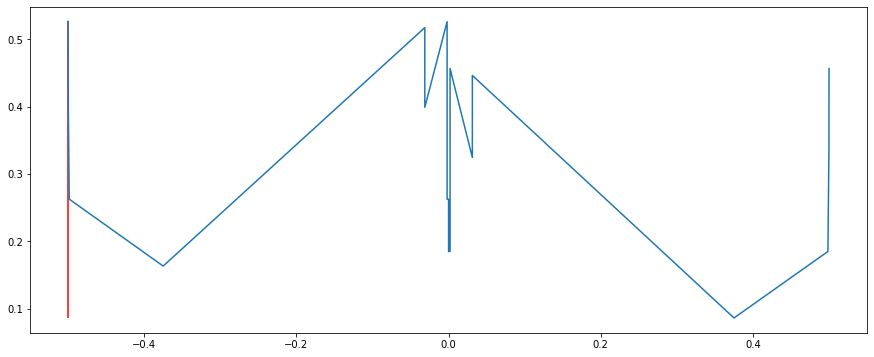

In [13]:
ax = full_number_corr.sort_index().plot(figsize=(15,6))
ax.vlines(secret_number, full_number_corr.min(), full_number_corr.max(), color='red')

In [14]:
full_number_corr.sort_values(ascending=False).iloc[:10]

-0.499939    0.526509
-0.001953    0.526256
-0.031246    0.517403
 0.499939    0.456563
 0.001953    0.456463
 0.031246    0.446309
-0.001952    0.413032
-0.499817    0.412132
-0.031239    0.398909
 0.001952    0.338622
dtype: float64

## Recover a secret number with helper function

/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)
../batina/weight_recovery.py:39: RuntimeWarning: invalid value encountered in greater_equal
  guess_numbers = y[(lo_range <= y) & (y <= hi_range)]
../batina/weight_recovery.py:39: RuntimeWarning: invalid value encountered in less_equal
  guess_numbers = y[(lo_range <= y) & (y <= hi_range)]
../batina/weight_recovery.py:80: RuntimeWarning: invalid value encountered in multiply
  data=np.vectorize(hamming_weight)(known_inputs.reshape(-1, 1) * guess_numbers))
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)


CPU times: user 24 s, sys: 604 ms, total: 24.6 s
Wall time: 24.6 s


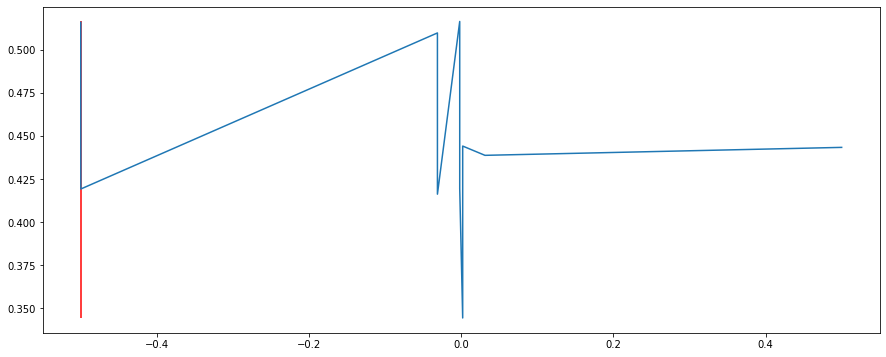

In [19]:
%%time
from weight_recovery_helper import *
full_number_corr = batina_recover_weight(secret_number=secret_number, 
                                         guess_range=guess_range,
                                         mantissa_nbits=12,
                                         noise=None)
ax = full_number_corr.sort_index().plot(figsize=(15,6))
ax.vlines(secret_number, full_number_corr.min(), full_number_corr.max(), color='red')

In [20]:
full_number_corr.sort_values(ascending=False).iloc[:10]

-0.001953    0.516365
-0.499939    0.515859
-0.031246    0.509714
 0.001953    0.444117
 0.499939    0.443353
 0.031246    0.438740
-0.001952    0.419576
-0.499817    0.419230
-0.031239    0.416222
 0.001952    0.344435
dtype: float64

## Recover multiple secret numbers

In [50]:
SECRET_VALUE='secret value'
GUESSED_VALUE = 'guessed value'
CORRELATION='correlation'
df_index = [SECRET_VALUE, GUESSED_VALUE, CORRELATION]

In [51]:
def add_noise_to_signal(signal, snr, freq):
    """
    add noise to the signal
    :param signal: signal
    :param snr: signal to noise ratio 
    :param freq: frequency of noise 
    :return: signal with noise
    """
    sig_max = signal.max()
    sig_min = signal.min()
    return pd.Series(signal).apply(lambda x: x  +
                                   np.average(np.random.normal(0.0, (sig_max-sig_min)/snr, freq)))

In [49]:
guess_range = (-5.0, 5.0)
precision = 1e-3
n_secret_numbers = 100
secret_numbers = np.concatenate((
    np.random.uniform(guess_range[0], guess_range[1], int(n_secret_numbers*2/4) ),
    np.random.uniform(guess_range[0]*3e-1, guess_range[1]*3e-1, int(n_secret_numbers*1/4)),
    np.random.uniform(guess_range[0]*1e-1, guess_range[1]*1e-1, int(n_secret_numbers*1/4))
))
np.random.shuffle(secret_numbers)
signal_to_noise_ratio = 0.5
print('secret_numbers.shape = %s' % (str(secret_numbers.shape)))

## Batina

In [53]:
%%time
# start guessing... - without noise
batina_results = pd.DataFrame(dtype=np.float32, columns=df_index)
for value in secret_numbers:
    s = batina_recover_weight(secret_number=value,
                              guess_range=guess_range,
                              mantissa_nbits=mantissa_nbits)
    s.name = CORRELATION
    df = pd.DataFrame(s).reset_index().rename(columns={'index': GUESSED_VALUE})
    df[SECRET_VALUE] = value
    batina_results = pd.concat([batina_results, df], axis=0, ignore_index=True)

../batina/weight_recovery.py:39: RuntimeWarning: invalid value encountered in greater_equal
  guess_numbers = y[(lo_range <= y) & (y <= hi_range)]
../batina/weight_recovery.py:39: RuntimeWarning: invalid value encountered in less_equal
  guess_numbers = y[(lo_range <= y) & (y <= hi_range)]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


CPU times: user 1min 37s, sys: 2.36 s, total: 1min 39s
Wall time: 1min 39s


In [54]:
batina_results

,secret value,guessed value,correlation
0,0.120876,0.120880,0.488730
1,0.120876,0.120865,0.471493
2,0.120876,0.120895,0.428322
3,0.120876,-0.120880,0.396822
4,0.120876,0.120834,0.390808
5,0.120876,-0.120865,0.385731
6,0.120876,0.120850,0.372417
7,0.120876,0.120926,0.366971
8,0.120876,0.120911,0.365829
9,0.120876,0.120972,0.364699


In [55]:
from datetime import datetime
from os import path

fname = path.join(TEST_RESULT_DIR, 
                  'batina_results-%s.csv' % (datetime.now().strftime("%Y%m%d_%H%M%S")))
batina_results.to_csv(fname)
print('save results in %s' % fname)

save results in ./results/batina_results-20200609_151140.csv


In [56]:
%%time
# start guessing... - without noise
noise_batina_results = pd.DataFrame(dtype=np.float32, columns=df_index)
for value in secret_numbers:
    s = batina_recover_weight(secret_number=value, 
                              guess_range=guess_range,
                              mantissa_nbits=mantissa_nbits,
                              noise=(add_noise_to_signal, signal_to_noise_ratio, 200))
    s.name = CORRELATION
    df = pd.DataFrame(s).reset_index().rename(columns={'index': GUESSED_VALUE})
    df[SECRET_VALUE] = value
    noise_batina_results = pd.concat([noise_batina_results, df], axis=0, ignore_index=True)

../batina/weight_recovery.py:39: RuntimeWarning: invalid value encountered in greater_equal
  guess_numbers = y[(lo_range <= y) & (y <= hi_range)]
../batina/weight_recovery.py:39: RuntimeWarning: invalid value encountered in less_equal
  guess_numbers = y[(lo_range <= y) & (y <= hi_range)]
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: overflow encountered in ? (vectorized)
  outputs = ufunc(*inputs)
/usr/local/lib/python3.7/dist-packages/numpy/lib/function_base.py:2167: RuntimeWarning: invalid value encountered in ? (vectorized)
  outputs = ufunc(*inputs)


CPU times: user 1min 40s, sys: 2.43 s, total: 1min 42s
Wall time: 1min 42s


In [57]:
from datetime import datetime
from os import path

fname = path.join(TEST_RESULT_DIR, 
                  'noise_batina_results-%s.csv' % (datetime.now().strftime("%Y%m%d_%H%M%S")))
noise_batina_results.to_csv(fname)
print('save results in %s' % fname)

save results in ./results/noise_batina_results-20200609_151323.csv


### Statistics

In [58]:
ERROR = 'error'
def statistics(df):
    dft = df[[SECRET_VALUE, GUESSED_VALUE, CORRELATION]].astype(dtype=np.float64)
    dft[ERROR] = np.abs((dft[GUESSED_VALUE] - dft[SECRET_VALUE])/dft[SECRET_VALUE])    
    best_corr = dft.loc[dft.groupby(SECRET_VALUE)[CORRELATION].idxmax()]
    best_err = dft.loc[dft.groupby(SECRET_VALUE)[ERROR].idxmin()]
    return best_corr.T, best_err.T

In [59]:
batina_best_corr, batina_best_err = statistics(batina_results)
noise_batina_best_corr, noise_batina_best_err = statistics(noise_batina_results)

In [ ]:
study_score = batina_best_corr
(study_score.T[ERROR] < 1e-3).value_counts()

In [ ]:
study_score.T.sort_values(ERROR, ascending=False)[:10]

In [ ]:
study_score[6400][SECRET_VALUE]

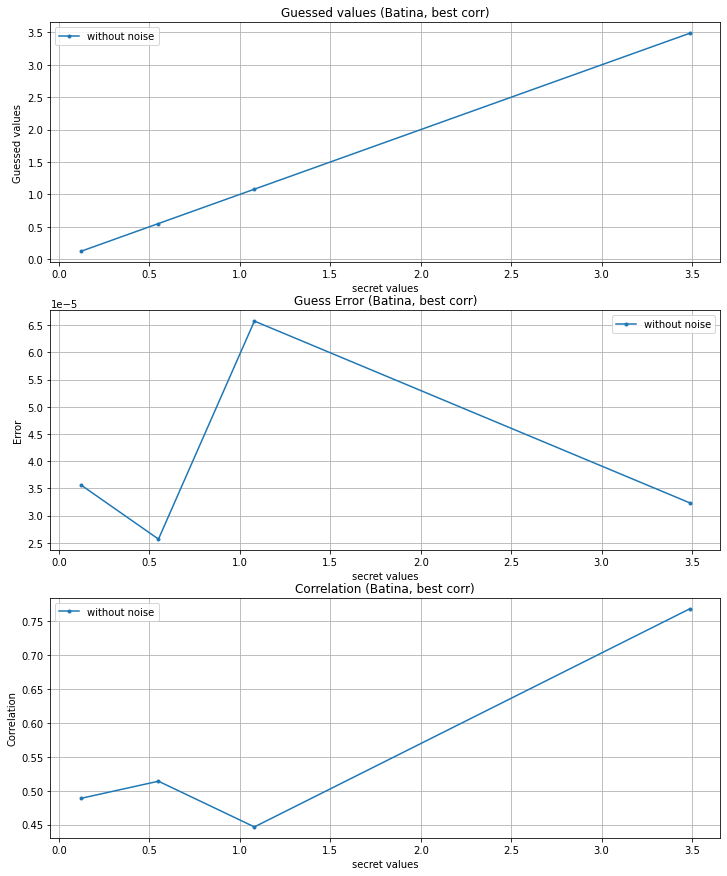

saved picture in nhw-20200609_151323597306.jpg


In [60]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = batina_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (Batina, best corr)')

df = batina_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (Batina, best corr)')

df = batina_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (Batina, best corr)')

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()
print('saved picture in %s' % fname)

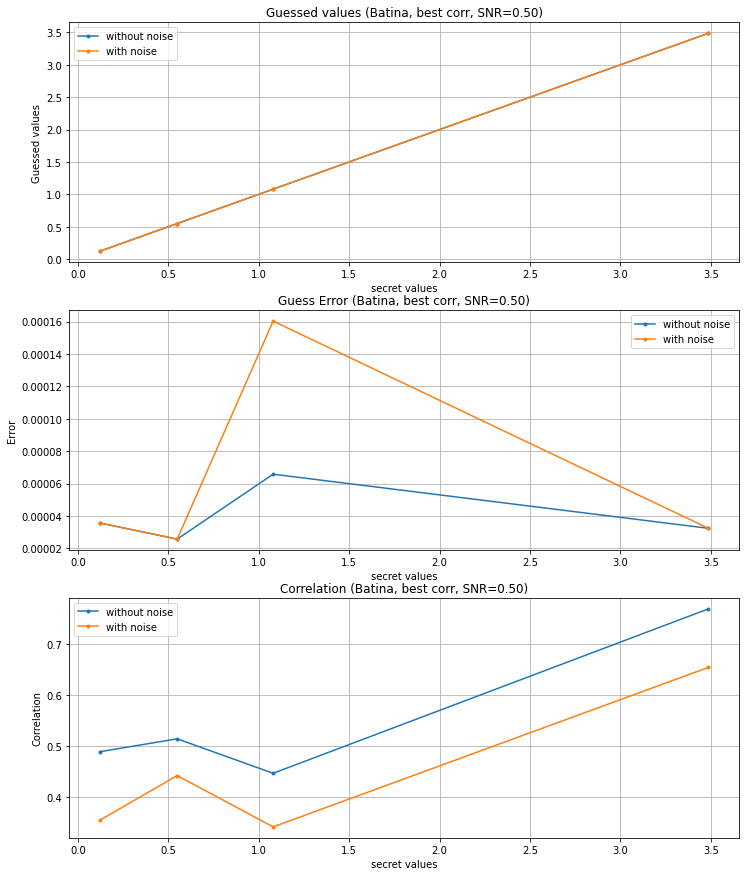

In [61]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(12, 15))
df = batina_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='without noise')
df = noise_batina_best_corr.T
df[[GUESSED_VALUE, SECRET_VALUE]].set_index(SECRET_VALUE)[GUESSED_VALUE].plot(ax=ax[0], marker='.', label='with noise')
ax[0].set_ylabel('Guessed values')
ax[0].set_title('Guessed values (Batina, best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = batina_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='without noise')
df = noise_batina_best_corr.T
df[[ERROR, SECRET_VALUE]].set_index(SECRET_VALUE)[ERROR].plot(ax=ax[1], marker='.', label='with noise')
ax[1].set_ylabel('Error')
ax[1].set_title('Guess Error (Batina, best corr, SNR=%0.2f)' % signal_to_noise_ratio)

df = batina_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='without noise')
df = noise_batina_best_corr.T
df[[CORRELATION, SECRET_VALUE]].set_index(SECRET_VALUE)[CORRELATION].plot(ax=ax[2], marker='.', label='with noise')
ax[2].set_ylabel('Correlation')
ax[2].set_title('Correlation (Batina, best corr, SNR=%0.2f)' % signal_to_noise_ratio)

for a in ax:
    a.legend()
    a.grid(True)
    a.set_xlabel('secret values')

from datetime import datetime
fname = 'nhw-%s.jpg' % (datetime.now().strftime("%Y%m%d_%H%M%S%f"))
plt.savefig(fname)
plt.show()